/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation MSE: 930.6561889648438, MAE: 12.458104133605957
Fold 2 - Validation MSE: 1144.574951171875, MAE: 12.649938583374023
Fold 3 - Validation MSE: 2326.426025390625, MAE: 19.46832847595215
Fold 4 - Validation MSE: 1209.521240234375, MAE: 18.047712326049805
Fold 5 - Validation MSE: 1157.775390625, MAE: 13.506362915039062
Mean Validation MSE: 1353.7907592773438, Std: 495.5944307021267
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 12299.8408 - mae: 67.2641 - val_loss: 15463.0449 - val_mae: 72.6009
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14062.1553 - mae: 72.0758 - val_loss: 15423.3789 - val_mae: 72.4484
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13338.7744 - mae: 69.7475 - val_loss: 15366.8037 - val_mae: 72.2383
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11759.5117 - mae: 66.7515 - val_loss: 15282.6689 - val_mae: 71.9326
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11826.4824 - mae: 67.4475 - val_loss: 1515

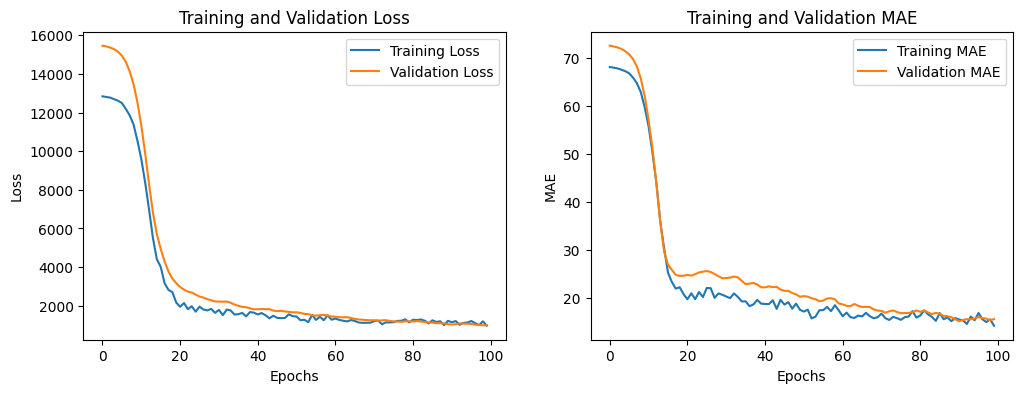

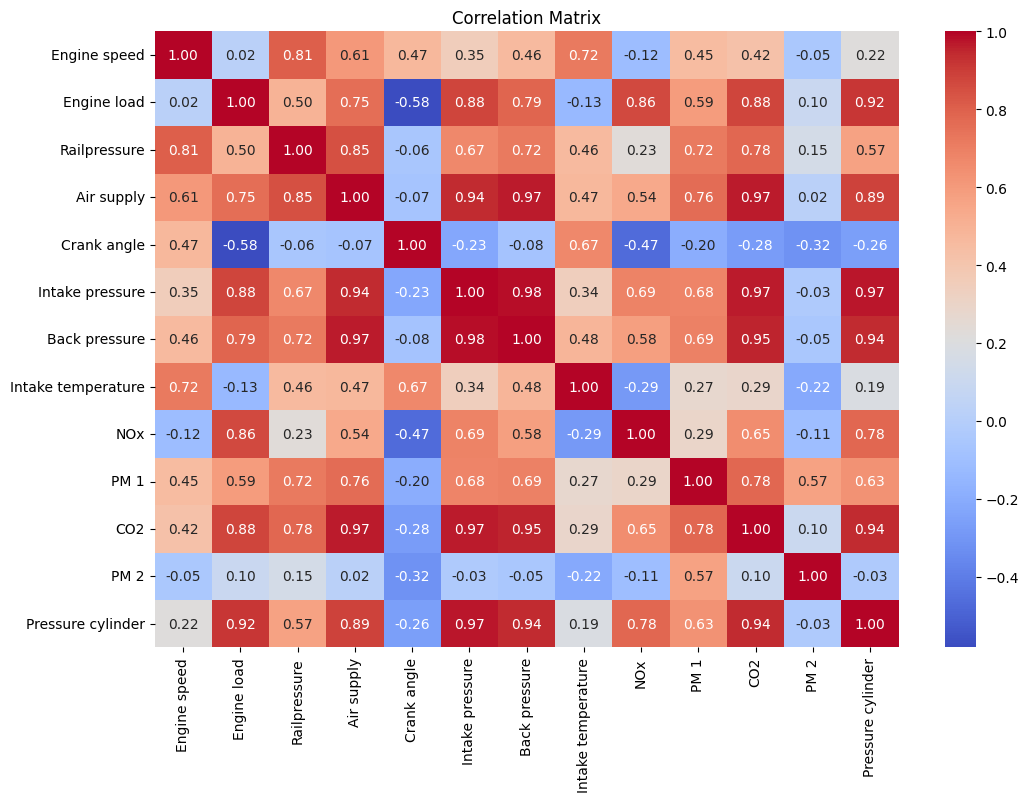

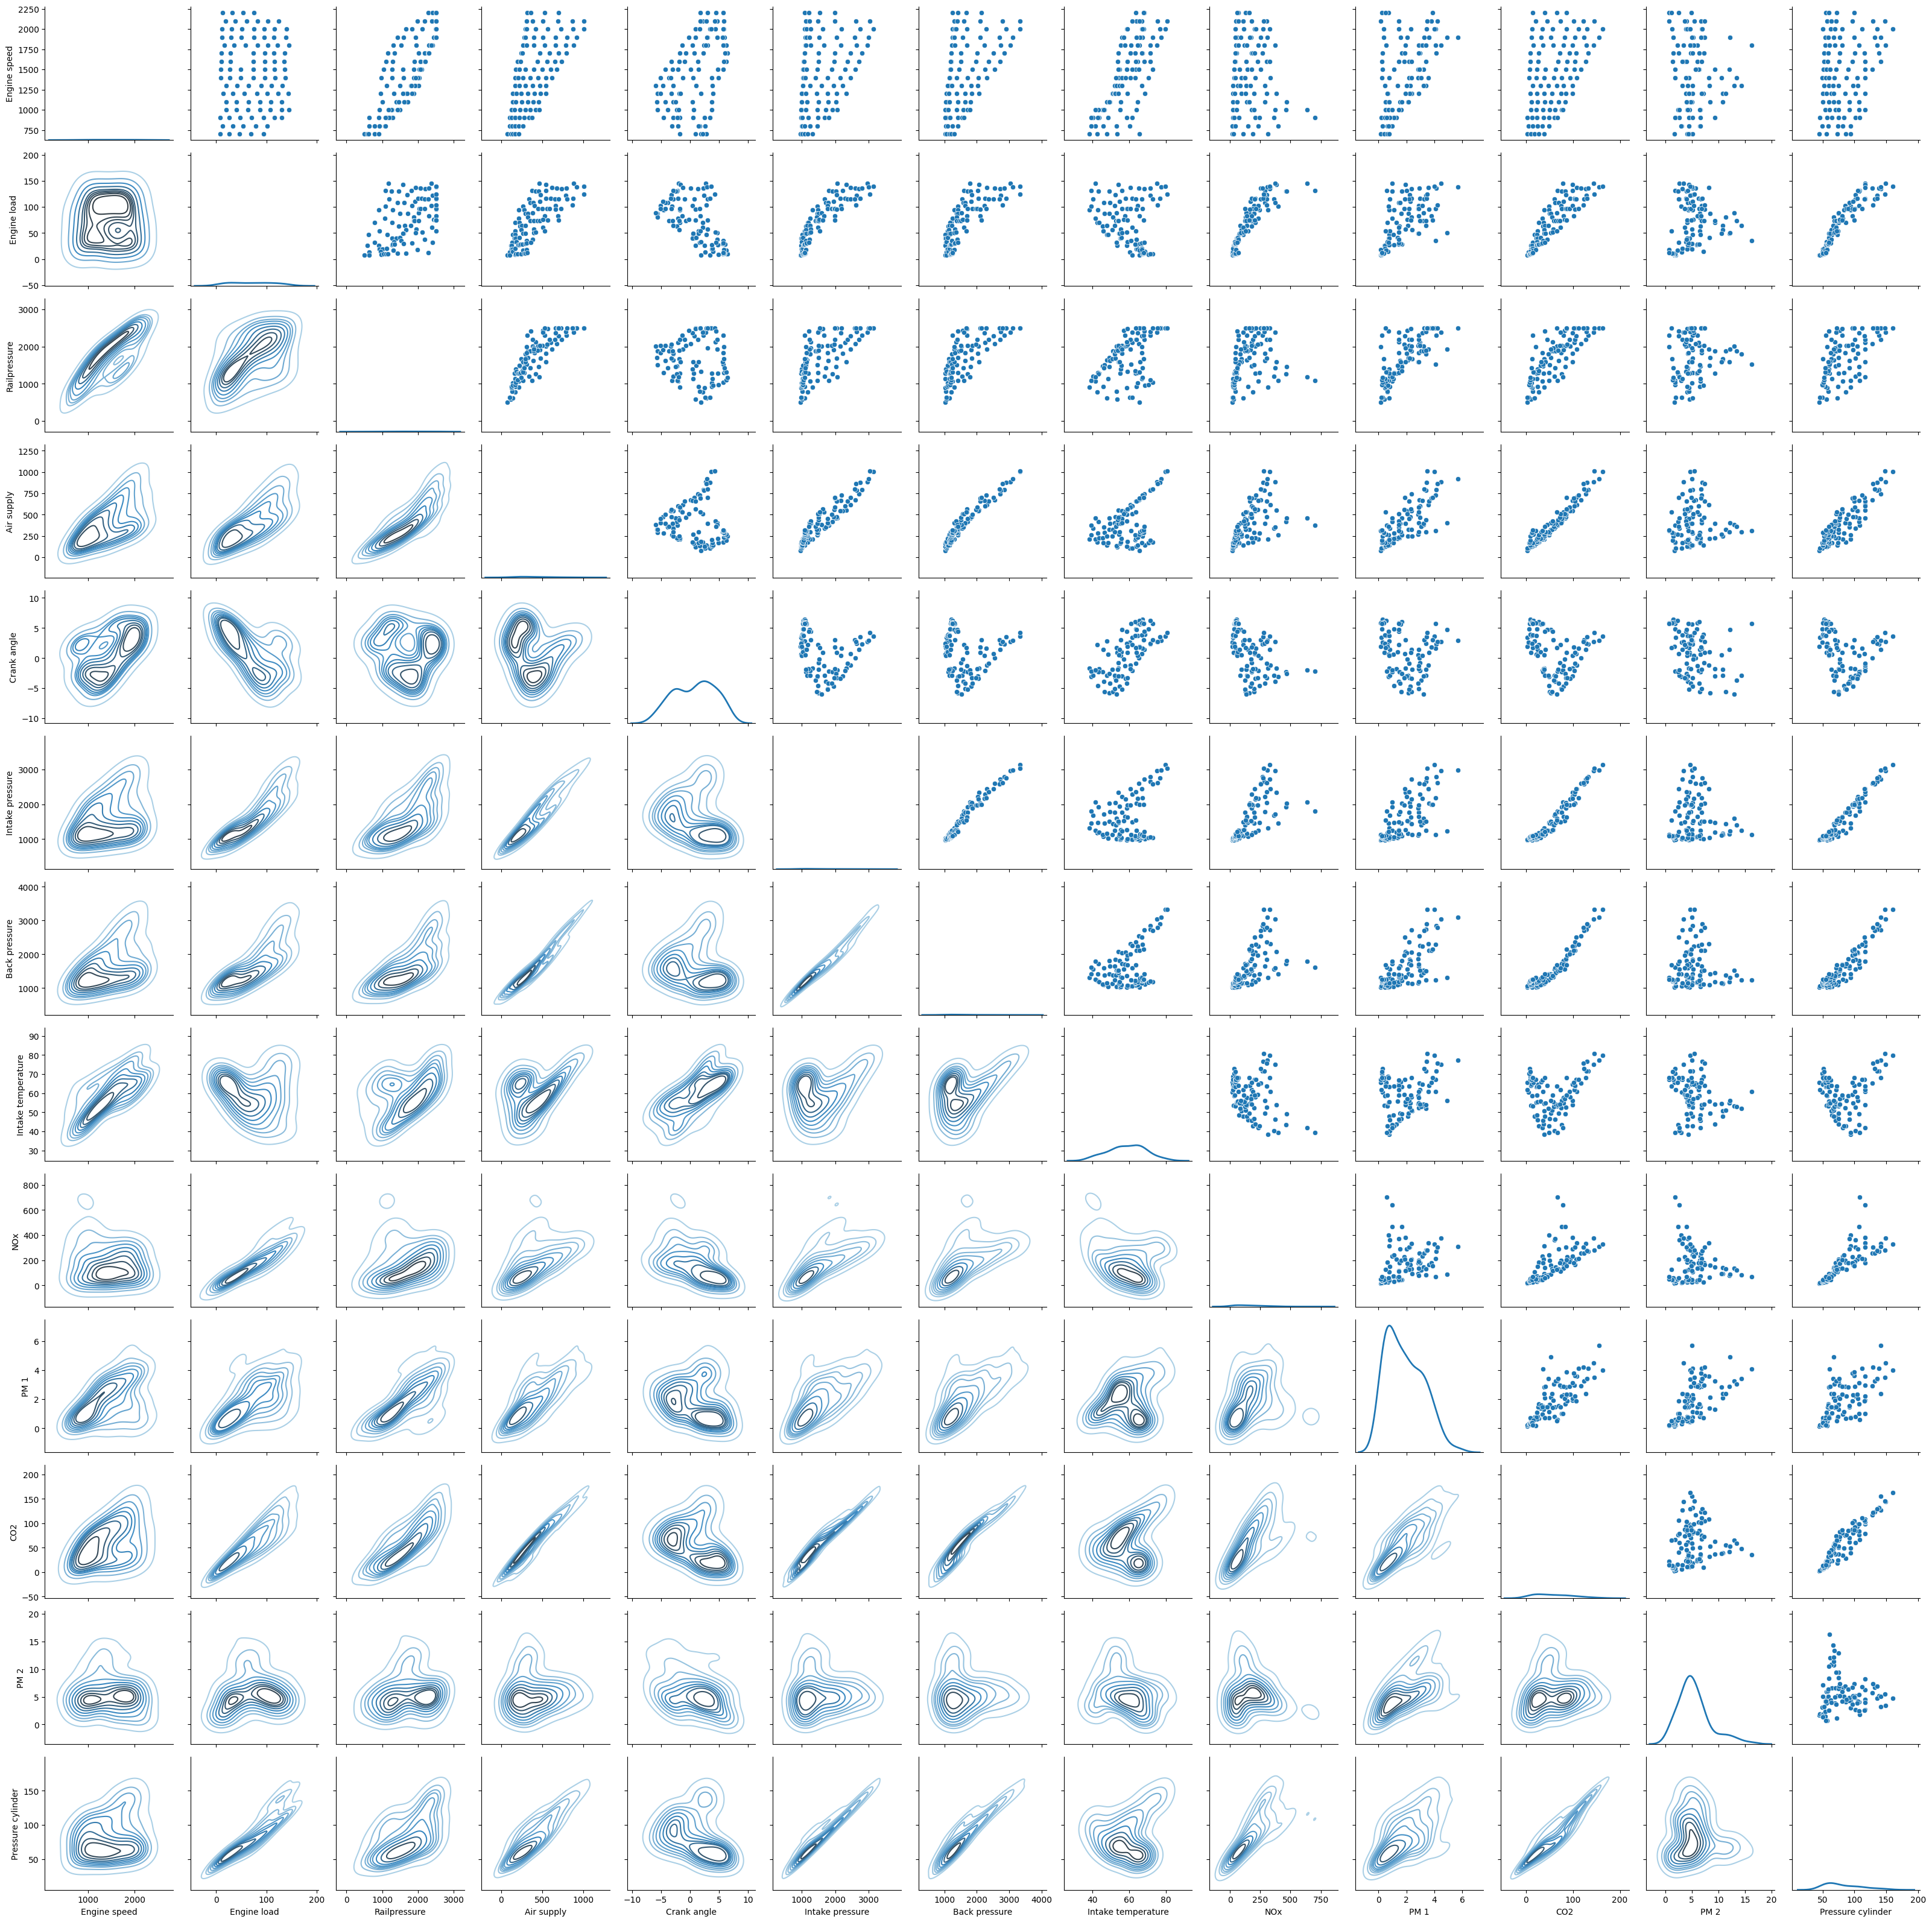

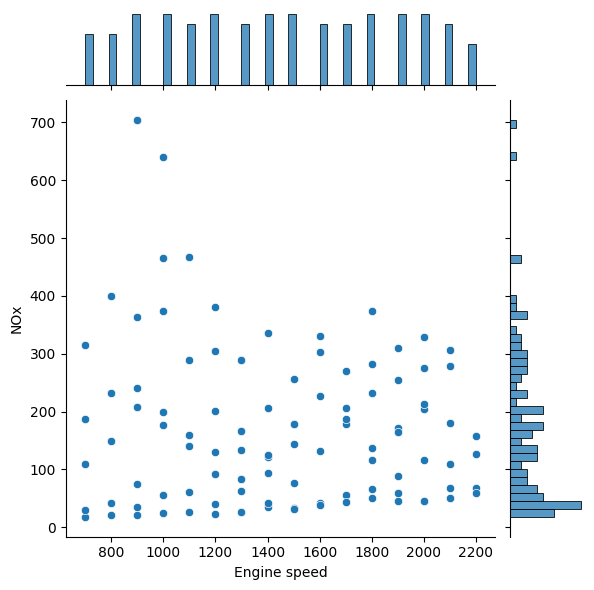

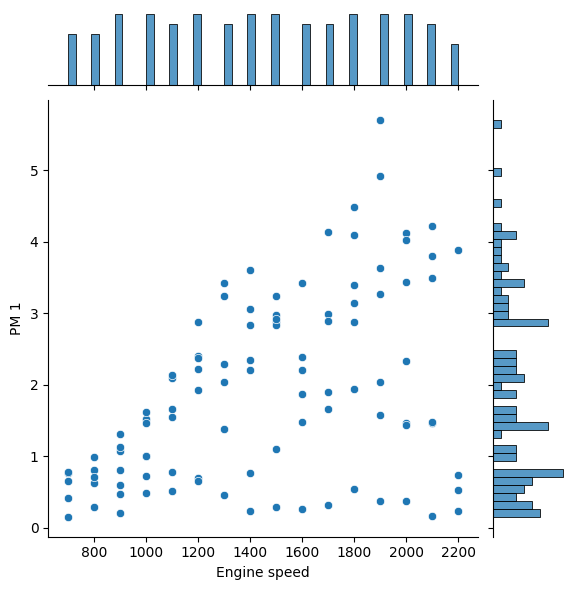

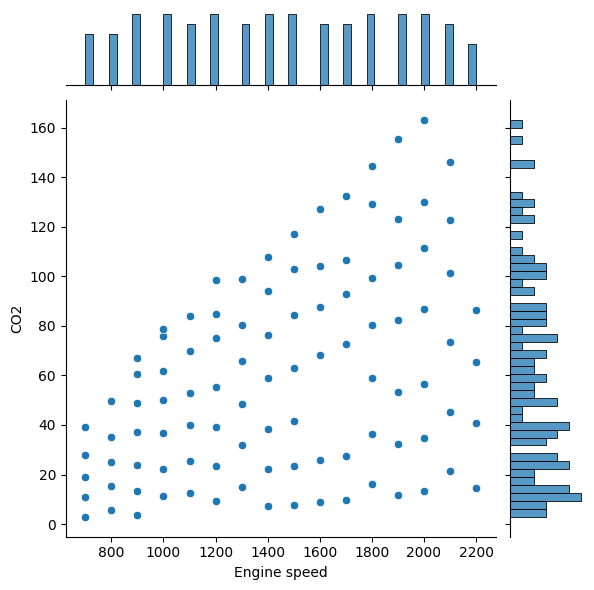

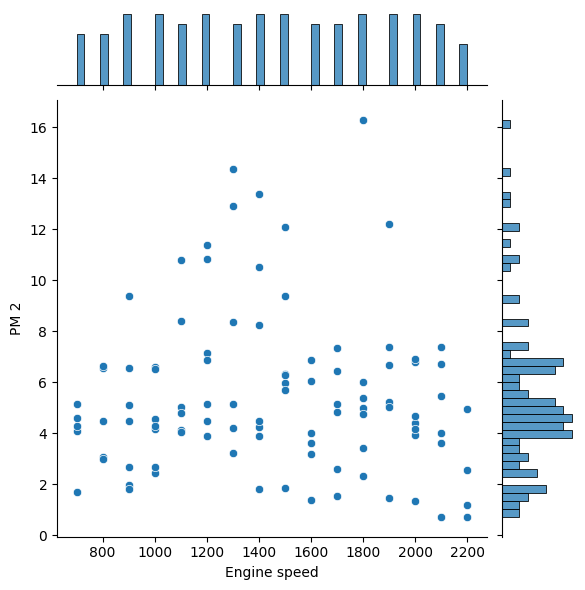

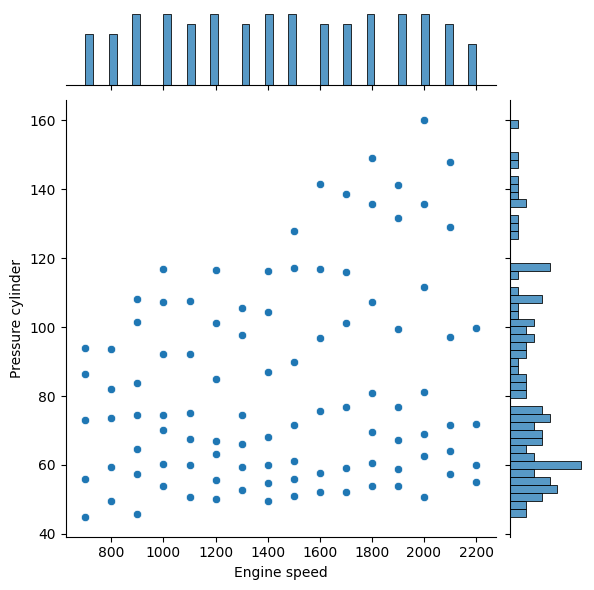

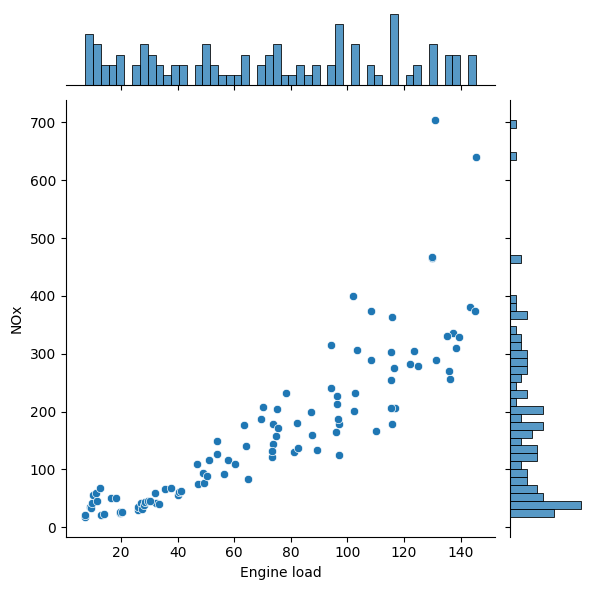

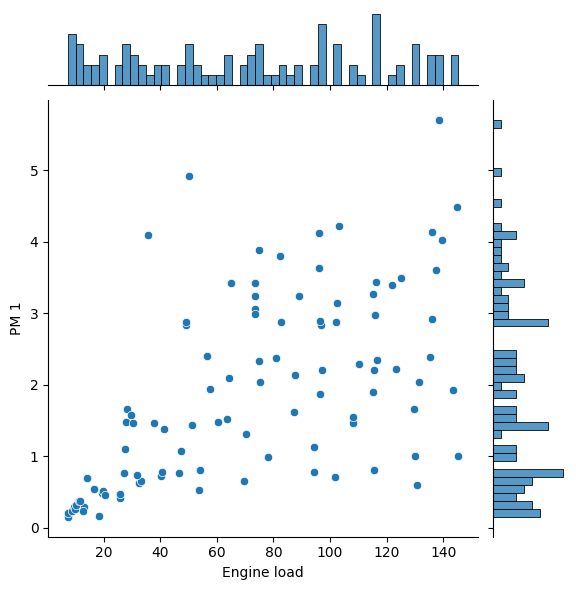

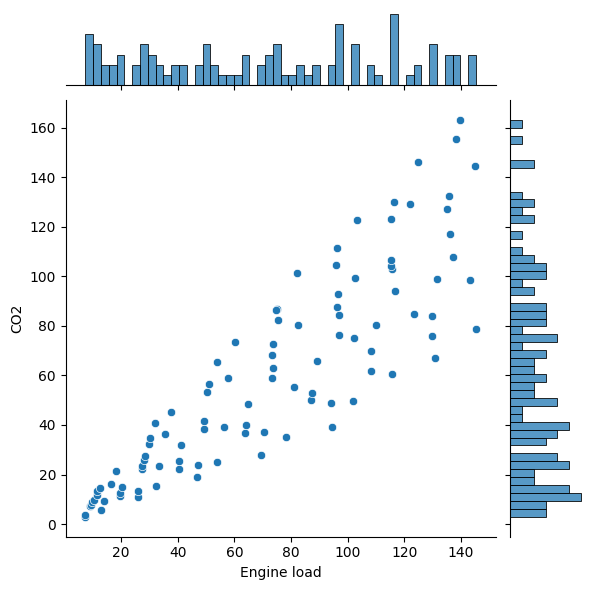

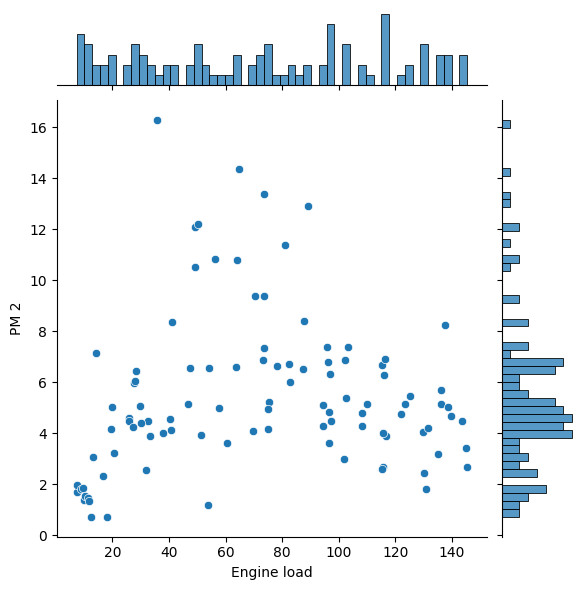

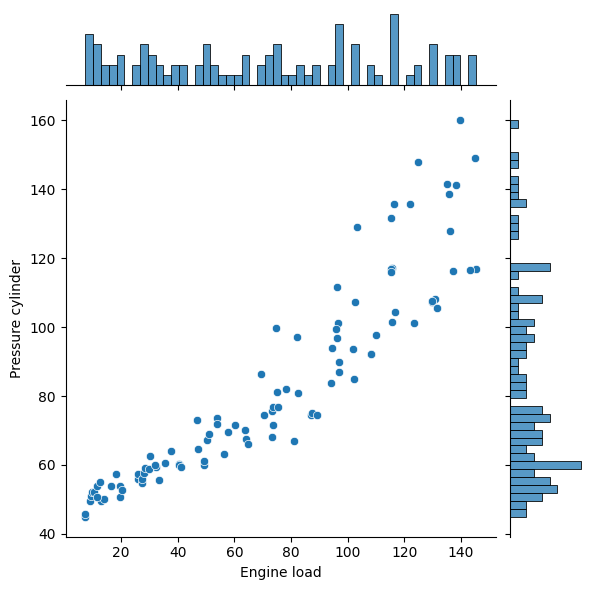

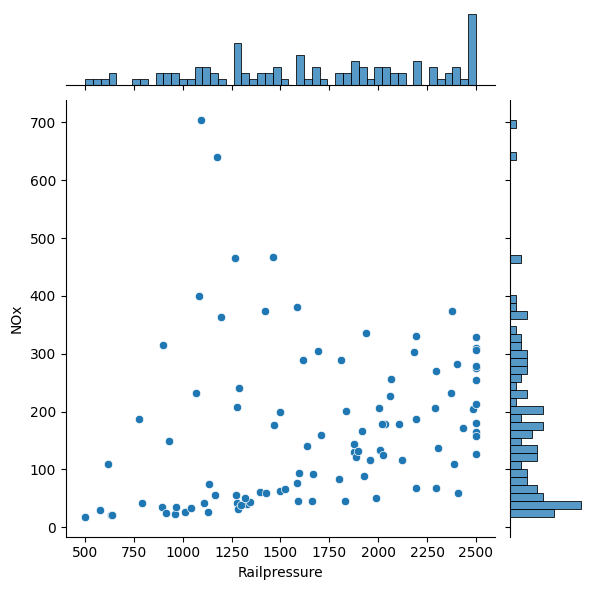

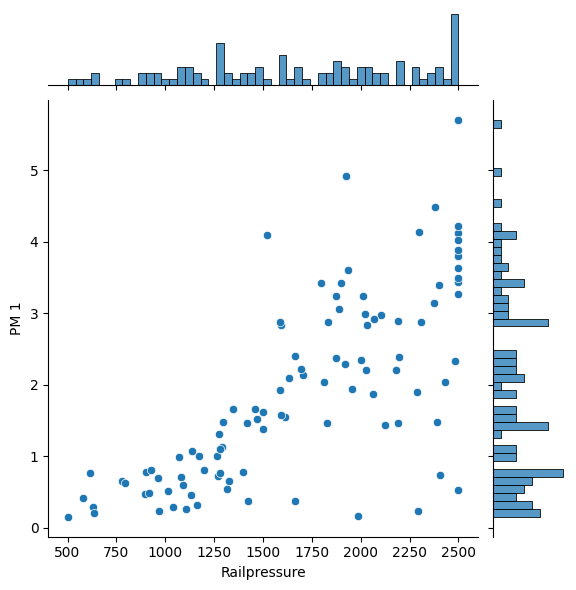

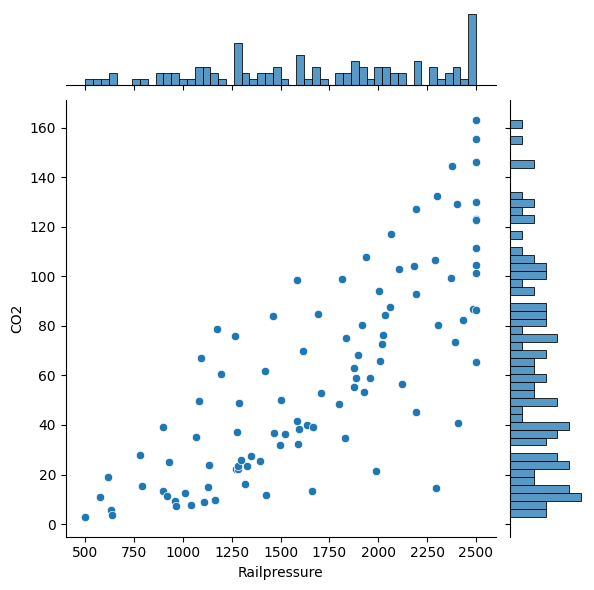

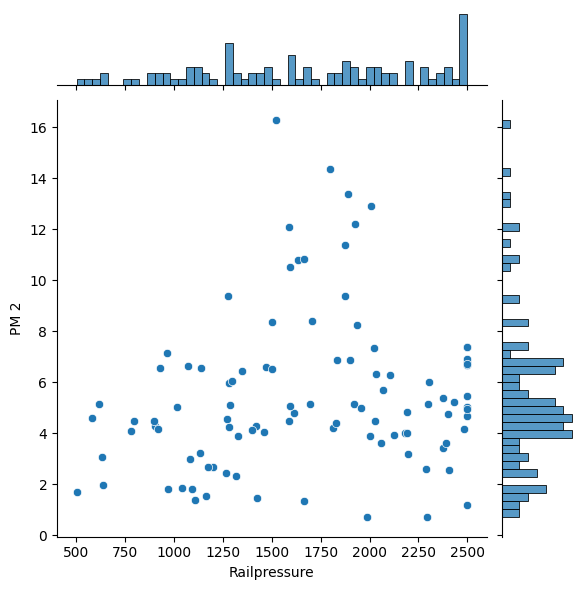

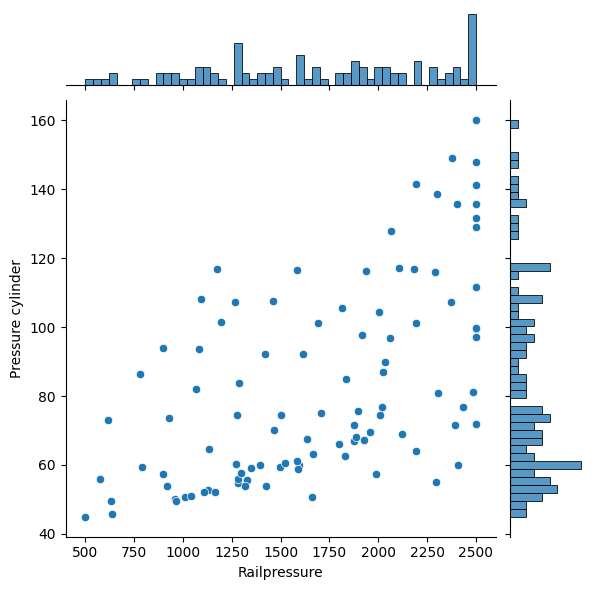

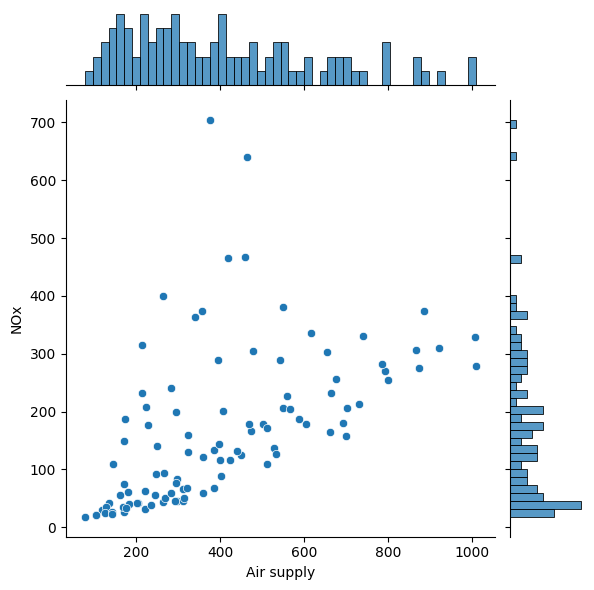

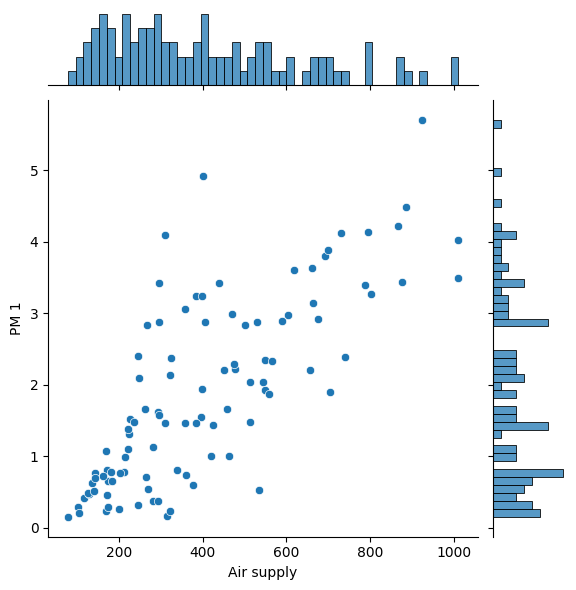

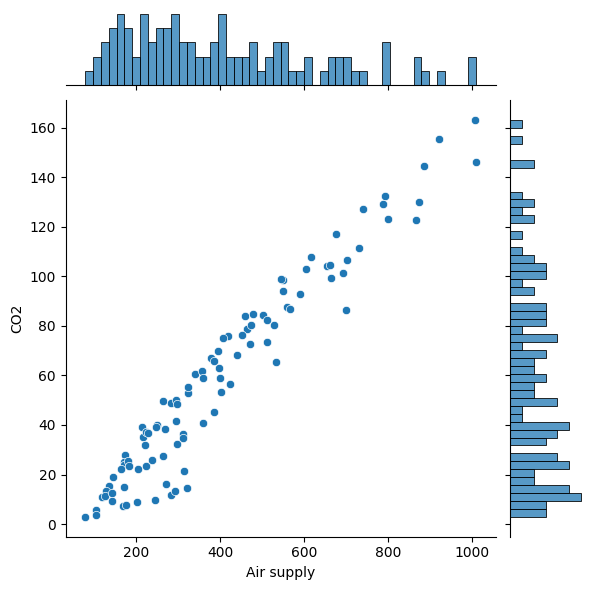

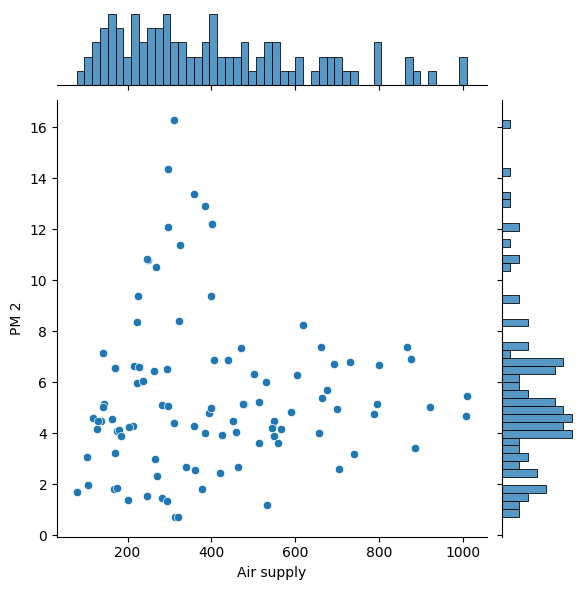

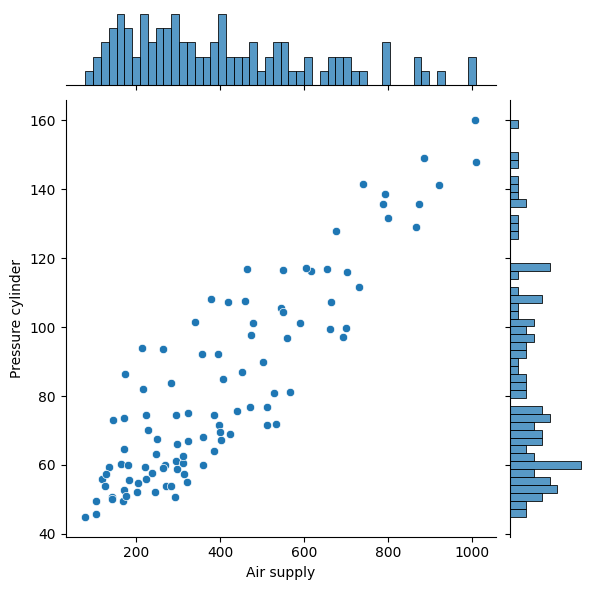

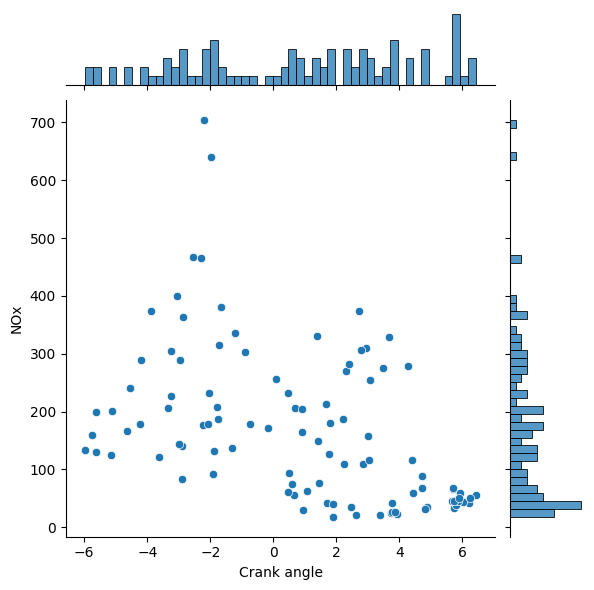

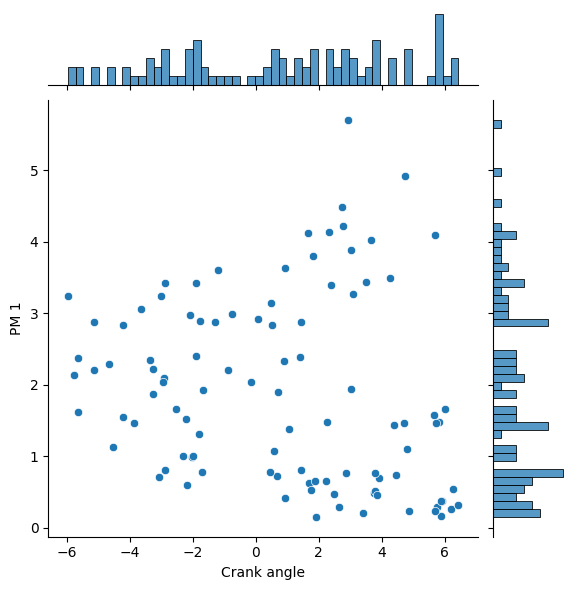

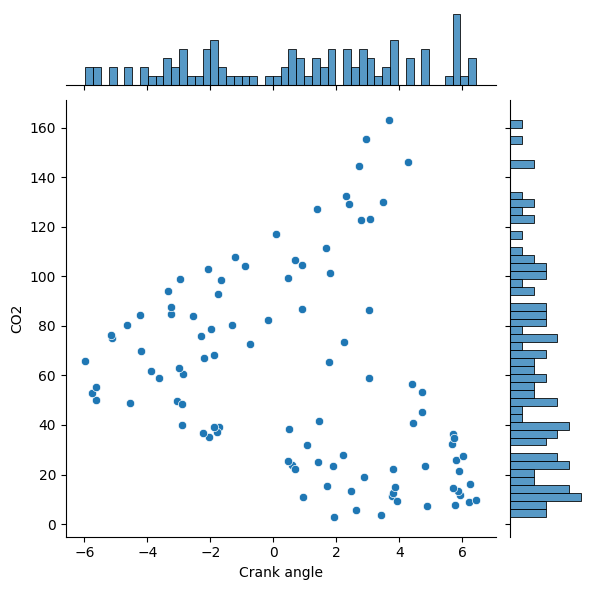

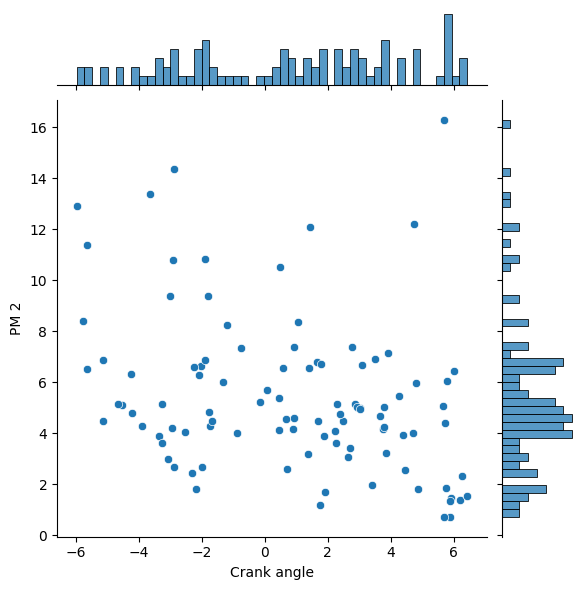

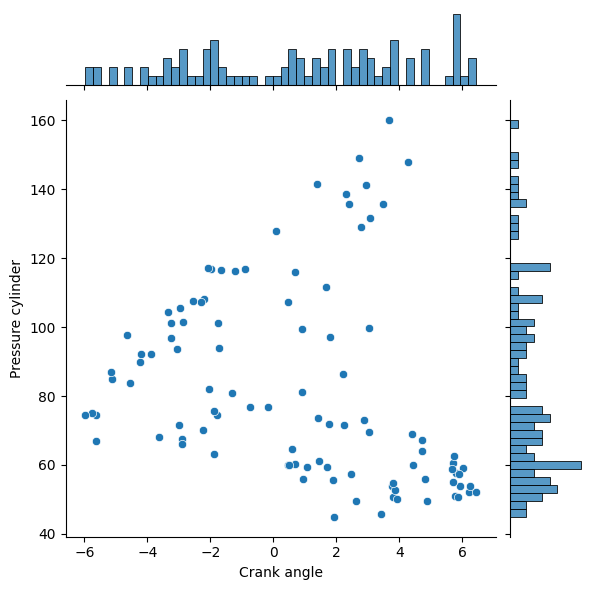

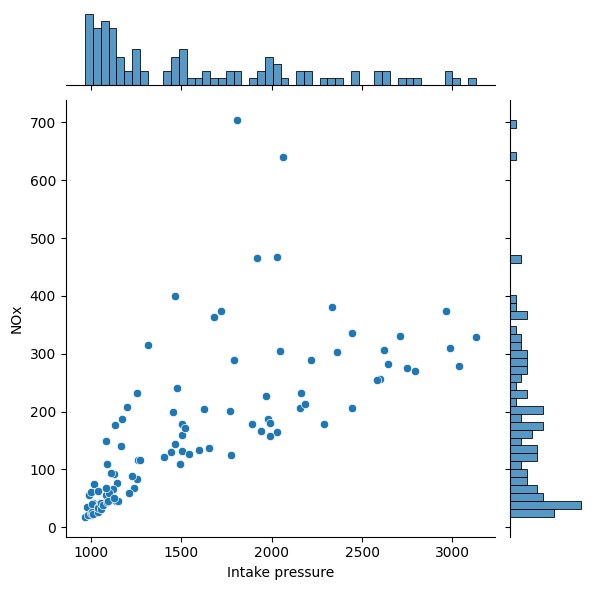

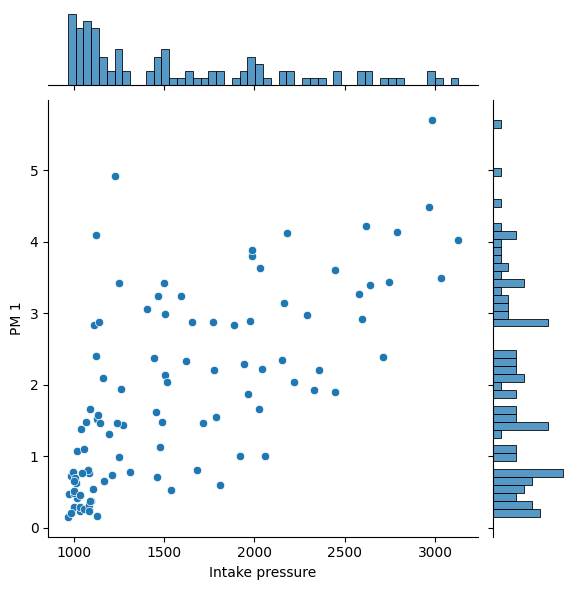

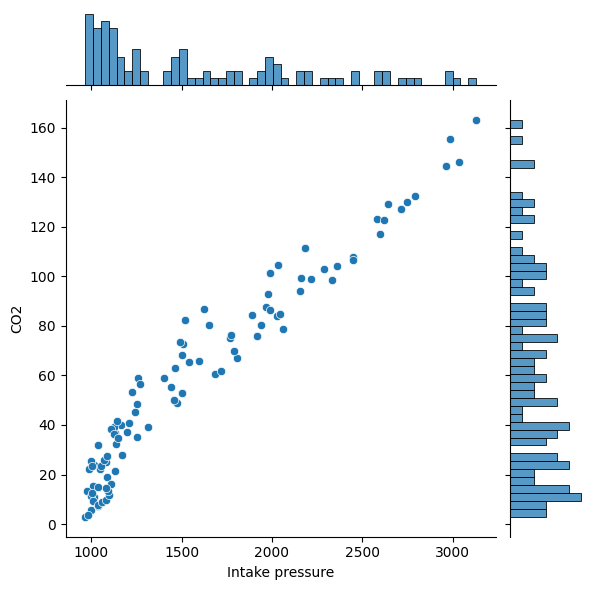

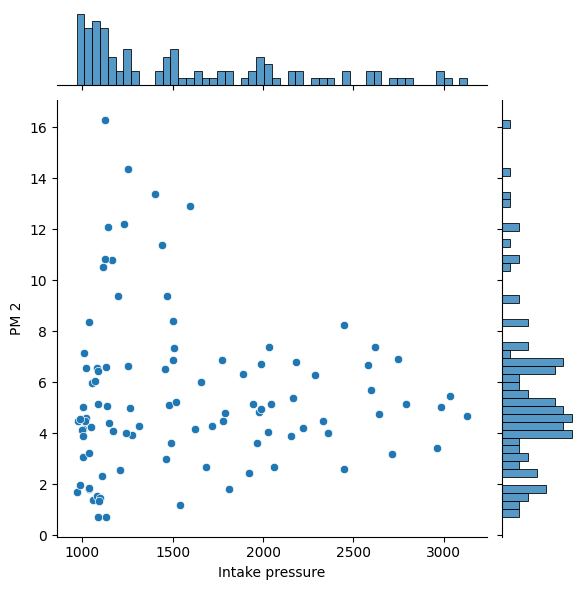

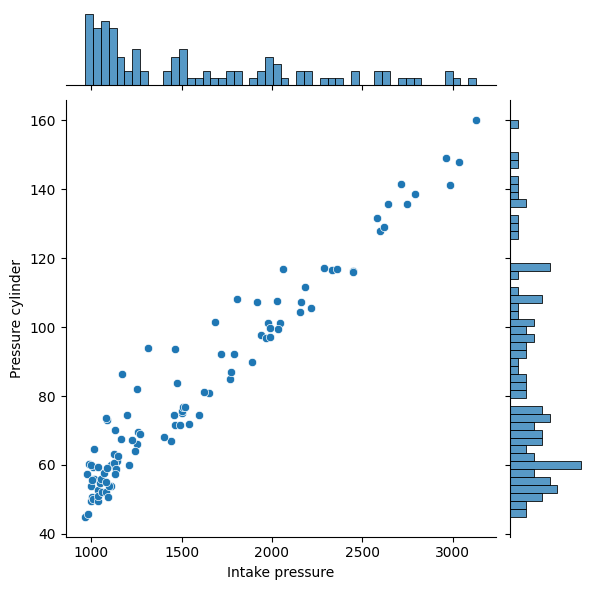

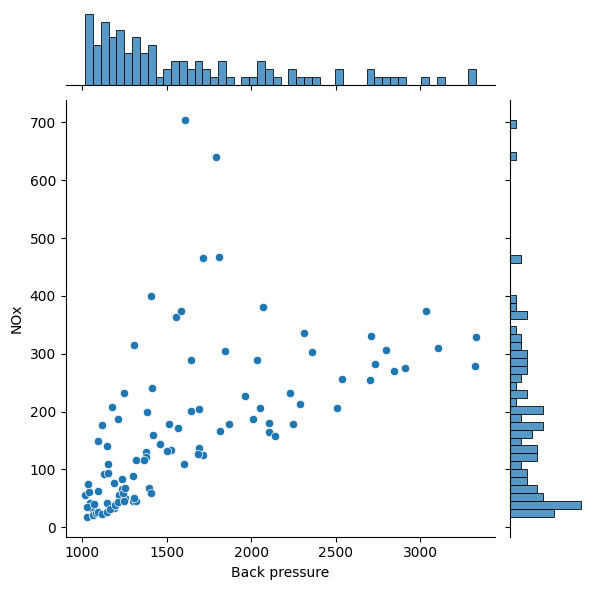

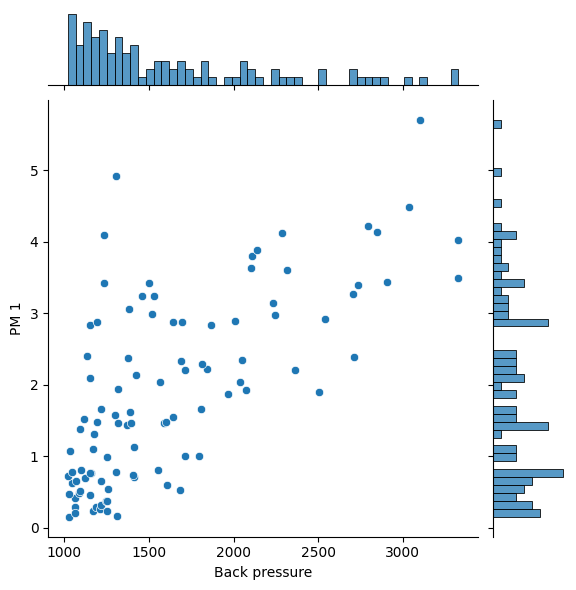

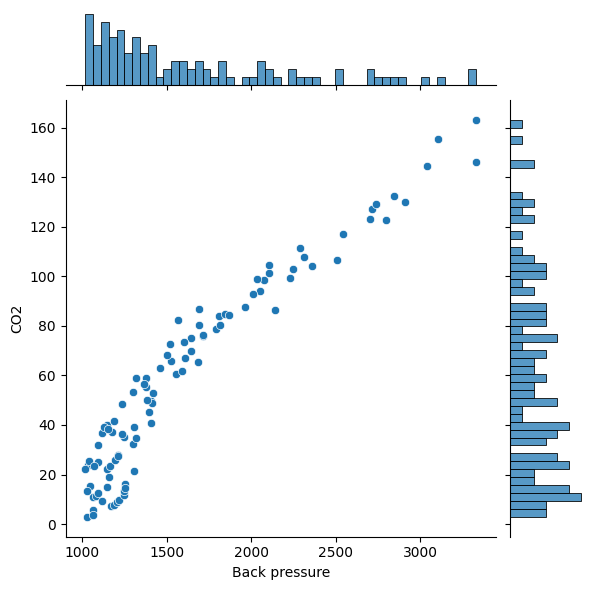

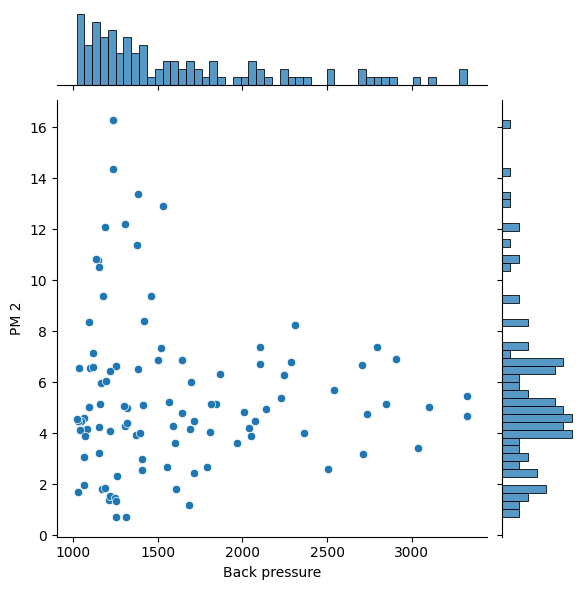

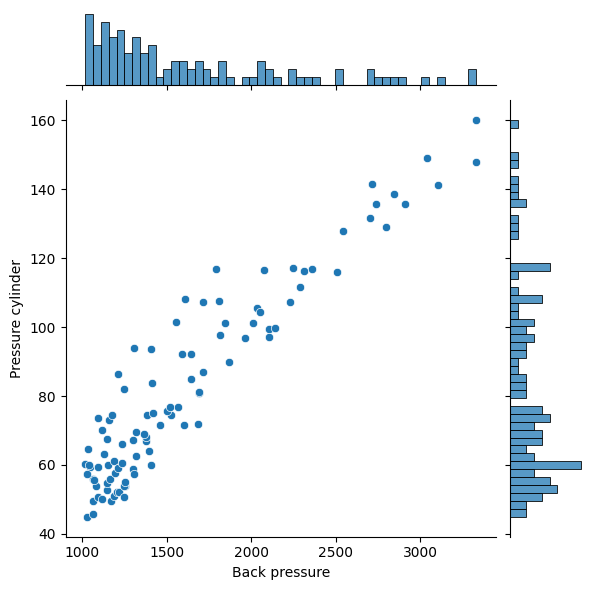

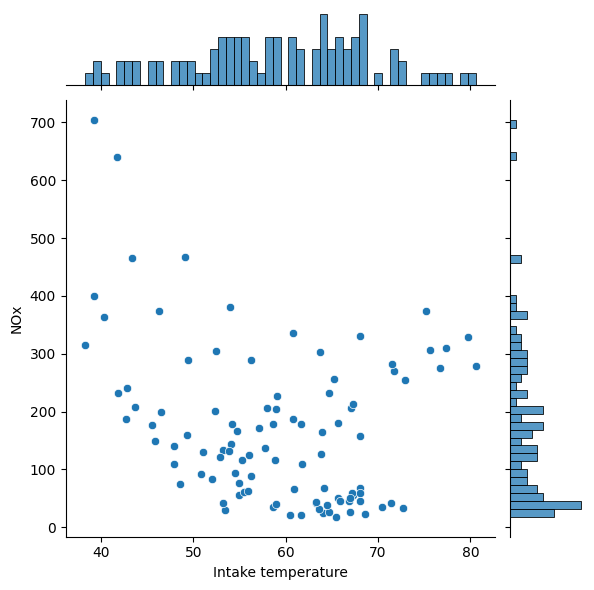

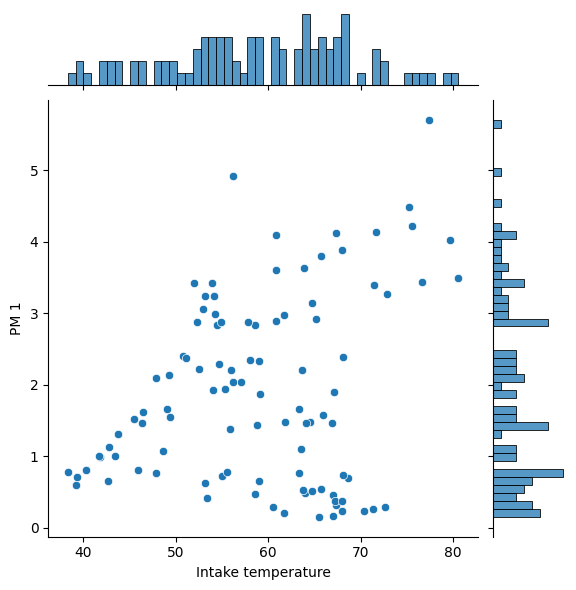

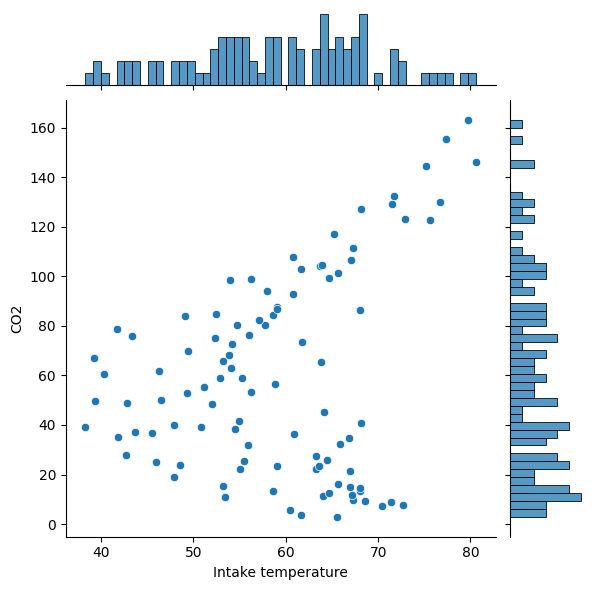

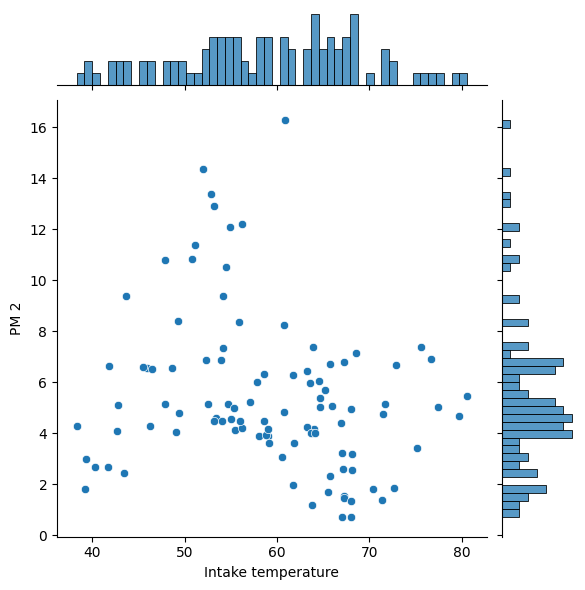

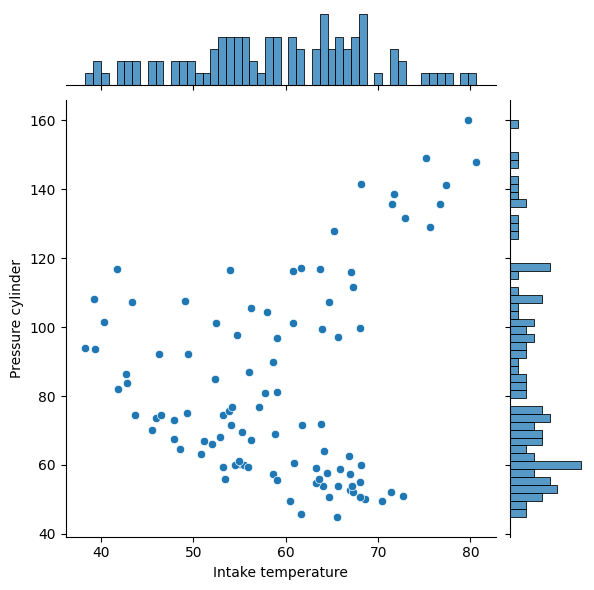

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Load dataset
file_path = "initial_data.csv" 
df = pd.read_csv(file_path)

# Define input and output columns
input_columns = df.columns[:8]
output_columns = df.columns[8:]

# Extract inputs and outputs
inputs = df[input_columns].values
outputs = df[output_columns].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Custom loss function to handle constraints
def custom_loss(y_true, y_pred):
    penalty = 0.0
    penalty += K.sum(K.maximum(y_pred[:, 2] - 6, 0))  # PM 1 constraint
    penalty += K.sum(K.maximum(y_pred[:, 3] - 16, 0))  # PM 2 constraint
    penalty += 10 * K.sum(K.maximum(y_pred[:, 4] - 160, 0))  # Pressure cylinder constraint
    return K.mean(K.square(y_true - y_pred)) + penalty

# Build the neural network model
def build_model():
    model = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(y_train.shape[1])  # Output layer with the number of outputs
    ])
    model.compile(optimizer='adam', loss=custom_loss, metrics=['mae'])
    return model

# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores = []
fold_no = 1
for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = build_model()
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=10,
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)
    
    val_mse, val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_scores.append(val_mse)
    print(f"Fold {fold_no} - Validation MSE: {val_mse}, MAE: {val_mae}")
    fold_no += 1

print(f"Mean Validation MSE: {np.mean(val_scores)}, Std: {np.std(val_scores)}")

# Train final model on full training data
final_model = build_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = final_model.fit(X_train, y_train, epochs=100, batch_size=10,
                          validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the model
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Predicting new data
new_data = np.random.rand(8).reshape(1, -1)  # Example new data
new_data_scaled = scaler.transform(new_data)
predictions = final_model.predict(new_data_scaled)
print(f'Predictions: {predictions}')

# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')

plt.show()

# Correlation Matrix
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pair Grid with KDE and Scatter Plots
pair_grid = sns.PairGrid(df)
pair_grid = pair_grid.map_upper(sns.scatterplot)
pair_grid = pair_grid.map_lower(sns.kdeplot, cmap='Blues_d')
pair_grid = pair_grid.map_diag(sns.kdeplot, lw=2)
plt.show()

# Joint Plot
for input_column in input_columns:
    for output_column in output_columns:
        sns.jointplot(x=df[input_column], y=df[output_column], kind='scatter', marginal_kws=dict(bins=50, fill=True))
        plt.show()